In [1]:
# 必要なライブラリの読み込み
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# データセットのダウンロード
# 2回目以降は実行する必要はありません
from urllib import request

# trainデータのダウンロード
url = 'https://s3-ap-northeast-1.amazonaws.com/ai-std/train.pickle'
request.urlretrieve(url, 'train.pickle')

# testデータのダウンロード
url = 'https://s3-ap-northeast-1.amazonaws.com/ai-std/test.pickle'
request.urlretrieve(url, 'test.pickle')

# ラベルデータのダウンロード
url = 'https://s3-ap-northeast-1.amazonaws.com/ai-std/label.pickle'
request.urlretrieve(url, 'label.pickle')

('label.pickle', <http.client.HTTPMessage at 0x1057bf3c8>)

In [3]:
# pickleのサンプルプログラム
import pickle

# 適当なオブジェクトを用意
obj = '保存されるオブジェクトです'

# Pythonオブジェクトをpickleファイルとして保存
with open('sample.pickle','wb') as f:
    pickle.dump(obj, f) # (Pythonオブジェクト, pickleファイル)

# pickleファイルをPythonオブジェクトとして読込
with open('sample.pickle','rb') as f:
    loaded_obj = pickle.load(f)  # (pickleファイル)

# 読み込んだオブジェクトを確認
print(loaded_obj)

保存されるオブジェクトです


In [4]:
# pickle形式のファイルを読み込む関数
# (保存されたpickleファイル)
def unpickle(file):
    # 保存されたpickleファイルを読み込み
    # 'rb'は｢読み込み専用(r)｣かつ｢バイト列(b)｣を意味する
    with open(file, 'rb') as f:
        return pickle.load(f, encoding='bytes')


In [5]:
# データの読み込みを実行
train = unpickle('train.pickle')
test = unpickle('test.pickle')
label = unpickle('label.pickle')

In [6]:
# trainデータの型を確認
print(type(train))
print(type(test))
print(type(label))

<class 'dict'>
<class 'dict'>
<class 'list'>


In [7]:
# クラスラベルを確認
label

['clock', 'cup', 'bicycle', 'television', 'chair']

In [8]:
# データを変数に格納
X_train = train['data']
y_train = train['label']
X_test = test['data']
y_test = test['label']

In [9]:
# サンプル数を確認
N_train = len(X_train)  
N_test = len(X_test)
print(N_train, N_test)

2500 500


In [10]:
# 画像サイズを確認
# 3チャンネル × 縦32ピクセル × 横32ピクセル
print(train['data'].shape)
print(test['data'].shape)

(2500, 3, 32, 32)
(500, 3, 32, 32)


In [11]:
# 正規化処理
X_train /= 255.0
X_test /= 255.0

In [12]:
# testデータのサンプルについて情報を確認する関数
# (testデータのindex)
def show_test_sample_info(index):
    # (channel, height, width)を(height, width, channel)に変換
    img = X_test[index].transpose(1,2,0)
    
    # 画像を出力
    plt.imshow(img)
    plt.show()
    
    # 正解ラベルを出力
    print('class: ' + label[y_test[index]])
    print('label: ' + str(y_test[index]))

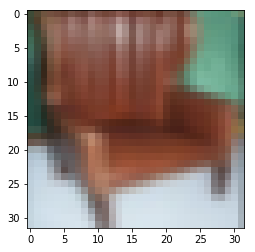

class: chair
label: 4


In [13]:
# testデータのサンプルについて情報を確認
# 引数のindexを変えていろいろな画像を出力してみましょう
show_test_sample_info(402)

In [14]:
# 必要なライブラリの読み込み
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers

/Users/akizakimasato/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
# CNNの定義
class CNN(chainer.Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=3, out_channels=64, ksize=4, stride=1, pad=2)
            self.conv2 = L.Convolution2D(in_channels=64, out_channels=128, ksize=4, stride=1, pad=2)
            self.conv3 = L.Convolution2D(in_channels=None, out_channels=128, ksize=4, stride=1, pad=2) # in_channelをNoneで省略
            self.fc4 = L.Linear(None, 512)
            self.fc5 = L.Linear(None, 5) # out_channelはクラス数と同じ5に設定
        
        
    def __call__(self, X):
        h = F.relu(F.max_pooling_2d(self.conv1(X), ksize=2)) # conv1の畳み込みのあとにMaxPoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv2(h), ksize=2)) # conv2の畳み込みのあとにMaxPpoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv3(h), ksize=2)) # conv3の畳み込みのあとにMaxPoolingを実行
        h = F.relu(self.fc4(h))
        return self.fc5(h)

In [16]:
# 必要なライブラリを読み込み
from chainer.datasets import tuple_dataset
from chainer.training import extensions
from chainer import optimizers, serializers, training, iterators

In [17]:
# 分類器インスタンスの生成
model = L.Classifier(CNN())

# optimizerの生成
optimizer = chainer.optimizers.SGD() # 今回はSGDを採用
optimizer.setup(model)               # モデルの構造を読み込ませる

# ミニバッチに含まれるサンプル数を指定
batchsize = 100

# epoch数を指定
n_epoch = 100

In [18]:
# trainerを定義
train = tuple_dataset.TupleDataset(X_train,y_train)
train_iter = iterators.SerialIterator(train,batch_size=batchsize,shuffle=True)
updater = training.StandardUpdater(train_iter,optimizer)
trainer = training.Trainer(updater,(n_epoch,'epoch'),out = 'result')

In [19]:
# Extensionsを利用してtrainerの機能を拡張
test = tuple_dataset.TupleDataset(X_test,y_test)
test_iter = iterators.SerialIterator(test,batch_size=batchsize,shuffle=False,repeat=False)
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss', 'validation/main/accuracy', 'validation/main/loss']))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

In [20]:
# 学習を実行
trainer.run()

epoch       main/accuracy  main/loss   validation/main/accuracy  validation/main/loss
1           0.2396         1.58721     0.248                     1.56988               
2           0.2884         1.55231     0.26                      1.5276                
3           0.3324         1.51943     0.434                     1.49286               
4           0.3772         1.49311     0.396                     1.46164               
     total [##................................................]  4.00%
this epoch [..................................................]  0.00%
       100 iter, 4 epoch / 100 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
5           0.388          1.45953     0.41                      1.45277               
6           0.3944         1.44268     0.386                     1.43212               
7           0.4448         1.40113     0.336                     1.40625               
8           0.416          1.39331     0.434                 

55          0.8192         0.529501    0.722                     0.800811              
56          0.8048         0.569784    0.75                      0.685293              
     total [############################......................] 56.00%
this epoch [..................................................]  0.00%
      1400 iter, 56 epoch / 100 epochs
   0.44658 iters/sec. Estimated time to finish: 0:41:03.140046.
57          0.8152         0.532663    0.74                      0.75338               
58          0.828          0.512464    0.716                     0.723572              
59          0.812          0.536298    0.734                     0.737918              
60          0.8148         0.532421    0.76                      0.686674              
     total [##############################....................] 60.00%
this epoch [..................................................]  0.00%
      1500 iter, 60 epoch / 100 epochs
   0.44571 iters/sec. Estimated time to finish

In [21]:
# モデルを利用して予測をする関数を定義
def predict(model, X):
    if len(X.shape) == 3:  # データ数が1の場合は、バッチサイズ分の次元を追加
        pred = model.predictor(X[None, ...]).data.argmax()
    else:  # データ数が2以上の場合はそのまま
        pred = model.predictor(X).data.argmax(axis=1)
    return pred

In [22]:
# 性能指標を確認
from sklearn import metrics
print('accuracy: %.3f' % metrics.accuracy_score(y_test, predict(model, X_test)))
print('recall: %.3f' % metrics.recall_score(y_test, predict(model, X_test), average='macro'))
print('precision: %.3f' % metrics.precision_score(y_test, predict(model, X_test), average='macro'))
print('f1_score: %.3f' % metrics.f1_score(y_test, predict(model, X_test), average='macro'))

accuracy: 0.790
recall: 0.790
precision: 0.791
f1_score: 0.789


In [23]:
# PlotReportによるグラフを出力する関数
from pylab import box
def show_graph(src):
    img =  plt.imread(src)
    xpixels, ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")

    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()

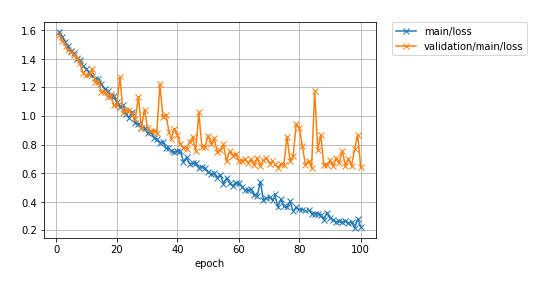

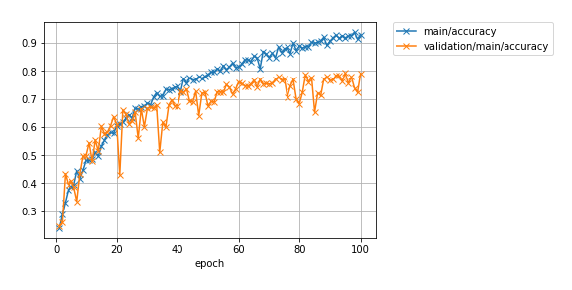

In [24]:
# 精度と誤差をグラフ描画
show_graph('result/loss.png')
show_graph('result/accuracy.png')

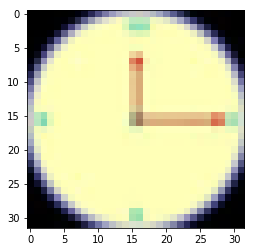

class: clock
label: 0
predict: 0
正解です｡


In [25]:
# indexを指定
index = 1

# 画像を出力
show_test_sample_info(index)

# 指定のindexが与えられたtestデータについて確認
pred = predict(model, X_test[index])
print('predict: {}'.format(pred))

# 正解か不正解かを出力
if pred == y_test[index]:
    print('正解です｡')
else:
    print('間違いです｡')

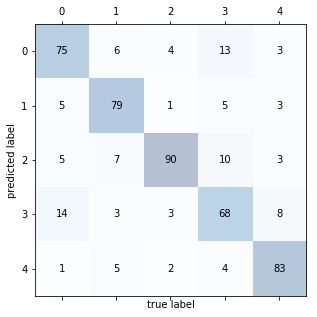

In [26]:
from sklearn.metrics import confusion_matrix as cm

# 混同行列きれいに出力する関数
def plot_cm(y_true, y_pred):
    confmat = cm(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xticks(np.arange(0, 5, 1))                               # x軸の目盛りを指定
    plt.yticks(np.arange(0, 5, 1))  
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()
    
# 混同行列を出力
result = predict(model, X_test)
plot_cm(result, y_test)

In [27]:
# ラベルを確認
print(label)

['clock', 'cup', 'bicycle', 'television', 'chair']


In [28]:
# 予測が外れたtestデータを格納するリストを用意
errors = []

# すべてのtestデータをチェック
for i in range(len(y_test)):
    pred_1 = predict(model, X_test[i])
    if pred_1 != y_test[i]:
        # (index, 正解ラベル, 予測ラベル)をタプル形式で格納
        errors.append((i, label[y_test[i]], label[pred_1]))

In [29]:
# 誤分類の総数を出力
len(errors)

105

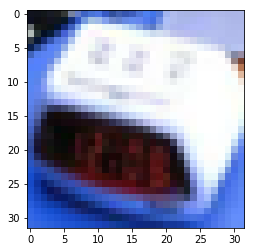

class: clock
label: 0
clock
television


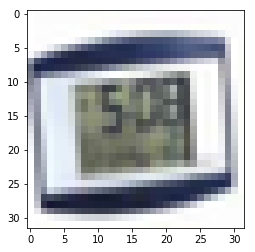

class: clock
label: 0
clock
television


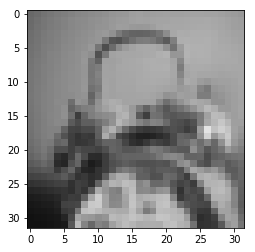

class: clock
label: 0
clock
bicycle


In [30]:
# 予測が外れた画像を集めて表示する
# 数が多いので3つだけ表示
for error_index, corr_label, pred_label in errors[:3]:
    show_test_sample_info(error_index)
    print(corr_label)
    print(pred_label)